In [ ]:
## import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional, just for confirmation

Using device: cuda


In [ ]:
test_data_import = pd.read_csv("/content/drive/MyDrive/results/test_data_not_normalised.csv")
train_data_nn_pre = pd.read_csv("/content/drive/MyDrive/results/train_data_not_normalised.csv")
val_data_nn_pre = test_data_import[test_data_import["patient_id"] == 'INH111'].copy()
test_data_nn_pre = test_data_import[test_data_import["patient_id"] != 'INH111'].copy()

print(f"Training Data has unique patient of [{train_data_nn_pre['patient_id'].unique()}]")
print(f"Testing Data has unique patient of [{test_data_nn_pre['patient_id'].unique()}]")
print(f"Validation Data has unique patient of [{val_data_nn_pre['patient_id'].unique()}]")
print(len(train_data_nn_pre), len(test_data_nn_pre), len(val_data_nn_pre))
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()), len(val_data_nn_pre["patient_id"].unique()))

Training Data has unique patient of [['INH001' 'INH004' 'INH007' 'INH010' 'INH011' 'INH012' 'INH015' 'INH127'
 'INH018' 'INH023' 'INH024' 'INH028' 'INH100' 'INH101' 'INH102' 'INH107'
 'INH114' 'INH108' 'INH109' 'INH110' 'INH112' 'INH115' 'INH119' 'INH120'
 'INH121' 'INH123' 'INH128' 'INH131' 'INH138' 'INH139']]
Testing Data has unique patient of [['INH002' 'INH003' 'INH006' 'INH013' 'INH014' 'INH017' 'INH025' 'INH027'
 'INH103' 'INH106' 'INH113' 'INH117' 'INH135']]
Validation Data has unique patient of [['INH111']]
326894 159025 12738
30 13 1


In [ ]:
train_data_nn_pre

,Unnamed: 0,patient_id,age_x,sex_x,season_x,br_avg,br_std,act_level,step_count,activity,...,pm10,no,no2,o3,so2,co,sex_y,age_y,cubic_meterers_tv,inhale_tv
0,0,INH001,65,Female,Winter,19.542938,6.395616,0.116685,0,Sitting bent backwards,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000573
1,1,INH001,65,Female,Winter,20.762518,2.593489,0.066786,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000613
2,2,INH001,65,Female,Winter,19.246227,2.828573,0.012011,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000560
3,3,INH001,65,Female,Winter,17.215359,4.588334,0.016393,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000550
4,4,INH001,65,Female,Winter,17.300472,2.968072,0.071856,9,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326889,526497,INH139,47,Female,Winter,14.888110,0.611812,0.013874,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000176
326890,526498,INH139,47,Female,Winter,14.972208,0.887404,0.014606,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000156
326891,526499,INH139,47,Female,Winter,15.359121,1.316184,0.014437,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000134
326892,526500,INH139,47,Female,Winter,15.506245,1.020111,0.014413,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000108


In [ ]:
train_data_nn = train_data_nn_pre.copy()
test_data_nn = test_data_nn_pre.copy()

In [ ]:
train_data_nn.columns

Index(['Unnamed: 0', 'patient_id', 'age_x', 'sex_x', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm10', 'no', 'no2', 'o3',
       'so2', 'co', 'sex_y', 'age_y', 'cubic_meterers_tv', 'inhale_tv'],
      dtype='object')

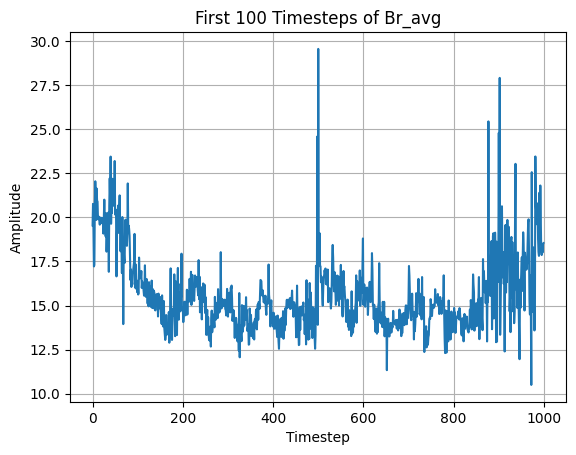

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_data_nn['br_avg'][:1000])
plt.title("First 100 Timesteps of Br_avg")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
# ============================== DEFINING INDIVIDUAL POSITIONING WITHIN DIFFERENT BATCHES ============================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return x

# ============================== DEFINING CLASS DATASET TO HANDLE THE DATA ============================
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size=8, forecast_steps=1, step=1):
        """
        Similar to professor's concat_timesteps but as a PyTorch Dataset
        """
        self.window_size = window_size
        self.forecast_steps = forecast_steps
        self.step = step

        # Create sliding windows
        n_samples, n_features = data.shape
        num_windows = (n_samples - window_size - forecast_steps) // step + 1

        self.windows = []
        self.targets = []

        for i in range(num_windows):
            start = i * step
            window = data[start:start + window_size]
            target = data[start + window_size:start + window_size + forecast_steps]

            self.windows.append(window)
            self.targets.append(target)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = torch.FloatTensor(self.windows[idx])
        target = torch.FloatTensor(self.targets[idx])

        # For single step prediction, squeeze the target
        if self.forecast_steps == 1:
            target = target.squeeze(0)

        return window, target


In [ ]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )
        src2 = self.dropout1(attn_output)
        src = self.norm1(src + src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src, attn_weights

class VariationalTimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_features: int = 11,
        d_model: int = 128,
        latent_dim: int = 64,  # New: Latent dimension
        nhead: int = 8,
        num_layers: int = 6,
        dim_feedforward: int = 512,
        dropout: float = 0.2,
        forecast_steps: int = 1,
        output_features: int = 11
    ):
        super().__init__()

        self.input_proj = nn.Linear(input_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        ## trying to plot attention's map

        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        # Latent projection
        self.mean_layer = nn.Linear(d_model, latent_dim)
        self.logvar_layer = nn.Linear(d_model, latent_dim)

        # Decoder maps from latent space → forecast
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_features * forecast_steps),
        )

        self.d_model = d_model
        self.latent_dim = latent_dim
        self.forecast_steps = forecast_steps
        self.output_features = output_features

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, src: torch.Tensor):
        """
        Args:
            src: (seq_len, batch, input_features)
        Returns:
            recon: (batch, forecast_steps, output_features)
            mu: (batch, latent_dim)
            logvar: (batch, latent_dim)
        """
        x = self.input_proj(src) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)

        attentions = []
        for layer in self.encoder_layers:
          x, attn_weights = layer(x)
          attentions.append(attn_weights)
        enc_out = x


        # Take last time-step
        last = enc_out[-1, :, :]  # (batch, d_model)

        # Latent space
        mu = self.mean_layer(last)      # (batch, latent_dim)
        logvar = self.logvar_layer(last)  # (batch, latent_dim)

        # Sample from latent distribution
        z = self.reparameterize(mu, logvar)  # (batch, latent_dim)

        # Decode
        recon = self.decoder(z)  # (batch, forecast_steps * output_features)

        if self.forecast_steps > 1:
            recon = recon.view(-1, self.forecast_steps, self.output_features)

        return recon, mu, logvar, attentions


In [ ]:
class LatentDiscriminator(nn.Module):
    def __init__(self, latent_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output: probability z is from N(0, I)
        )

    def forward(self, z):
        return self.net(z)

In [ ]:
## Inputting train model rollout
import torch.nn.functional as F
from torch.nn import BCELoss
import numpy as np

def train_model_aae_rollout(
    model,
    train_loader,
    val_loader,
    optimizer,
    discriminator,
    disc_optimizer,
    device,
    epochs=30,
    patience=5,
    min_delta=1e-4,
    adv_weight=0.01,
    scheduled_sampling_start=1.0,
    scheduled_sampling_end=0.0,
    scheduled_sampling_decay=0.95
):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    adversarial_loss = nn.BCELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    sampling_prob = scheduled_sampling_start

    for epoch in range(1, epochs + 1):
        model.train()
        discriminator.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # (batch, window_size, features)
            targets = targets.to(device)  # (batch, forecast_steps, features)

            inputs = inputs.permute(1, 0, 2)  # (window_size, batch, features)

            # ===== Phase 1: Train Discriminator =====
            with torch.no_grad():
                recon, mu, logvar, _ = model(inputs)
                z_fake = model.reparameterize(mu, logvar).detach()

            z_real = torch.randn_like(z_fake).to(device)
            real_labels = torch.ones(z_real.size(0), 1).to(device)
            fake_labels = torch.zeros(z_fake.size(0), 1).to(device)

            disc_optimizer.zero_grad()
            real_preds = discriminator(z_real)
            fake_preds = discriminator(z_fake)
            disc_loss = adversarial_loss(real_preds, real_labels) + \
                        adversarial_loss(fake_preds, fake_labels)
            disc_loss.backward()
            disc_optimizer.step()

            # ===== Phase 2: Train Model with Rollout =====
            optimizer.zero_grad()
            inputs_ar = inputs.clone()  # (window_size, batch, features)

            preds_ar = []
            for step in range(model.forecast_steps):
                # Forward pass
                recon_step, mu, logvar, _ = model(inputs_ar)

                # Get last prediction
                if model.forecast_steps > 1:
                    pred_step = recon_step[:, step, :]  # (batch, features)
                else:
                    pred_step = recon_step  # (batch, features)

                preds_ar.append(pred_step.unsqueeze(1))  # collect predictions

                # Scheduled sampling decision
                use_truth = np.random.rand() > sampling_prob

                next_input = targets[:, step, :] if use_truth else pred_step  # (batch, features)
                next_input = next_input.unsqueeze(0)  # (1, batch, features)

                # Append prediction to the sequence for next step
                inputs_ar = torch.cat([inputs_ar[1:], next_input], dim=0)

            preds_ar = torch.cat(preds_ar, dim=1)  # (batch, forecast_steps, features)
            recon_loss = F.mse_loss(preds_ar, targets, reduction='mean')

            # Adversarial regularization
            z_gen = model.reparameterize(mu, logvar)
            gen_preds = discriminator(z_gen)
            adv_loss = adversarial_loss(gen_preds, real_labels)

            loss = recon_loss + adv_weight * adv_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        discriminator.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.permute(1, 0, 2).to(device)
                targets = targets.to(device)

                outputs, _, _, _ = model(inputs)

                if model.forecast_steps > 1:
                    outputs = outputs.view(targets.shape[0], targets.shape[1], targets.shape[2])

                recon_loss = F.mse_loss(outputs, targets, reduction='mean')
                total_val_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"[Epoch {epoch:02d}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Disc Loss: {disc_loss.item():.4f} | Adv: {adv_loss.item():.4f} | SampleProb: {sampling_prob:.4f}")

        # Early Stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Decay scheduled sampling
        sampling_prob = max(scheduled_sampling_end, sampling_prob * scheduled_sampling_decay)


In [ ]:
# ## Useful to filter down!

# # Training Data has unique patient of [['INH001' 'INH004' 'INH007' 'INH010' 'INH011' 'INH012' 'INH015' 'INH127'
# #  'INH018' 'INH023' 'INH024' 'INH028' 'INH100' 'INH101' 'INH102' 'INH107'
# #  'INH114' 'INH108' 'INH109' 'INH110' 'INH112' 'INH115' 'INH119' 'INH120'
# #  'INH121' 'INH123' 'INH128' 'INH131' 'INH138' 'INH139']]
# # Testing Data has unique patient of [['INH002' 'INH003' 'INH006' 'INH013' 'INH014' 'INH017' 'INH025' 'INH027'
# #  'INH103' 'INH106' 'INH113' 'INH117' 'INH135']]

# train_data_nn_pre = train_data_nn_pre[train_data_nn_pre["patient_id"].isin(['INH001','INH004', 'INH007', 'INH102' ,'INH107' ,'INH114'])]
# test_data_nn_pre = test_data_nn_pre[test_data_nn_pre["patient_id"].isin(['INH002','INH014','INH017' ])]


# print(train_data_nn_pre["patient_id"].unique(), test_data_nn_pre["patient_id"].unique())
# print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()))

In [ ]:
train_data_nn_pre.columns

Index(['Unnamed: 0', 'patient_id', 'age_x', 'sex_x', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm10', 'no', 'no2', 'o3',
       'so2', 'co', 'sex_y', 'age_y', 'cubic_meterers_tv', 'inhale_tv'],
      dtype='object')

In [ ]:
## ================= INSTANTIATING AND CALLING THE MODEL ==================
# Hyperparameters
window_size = 8
forecast_steps = 2
batch_size = 64
d_model = 128
nhead = 8
num_layers = 6
dim_feedforward = 512
dropout = 0.2
lr = 1e-3
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_train = train_data_nn_pre.copy()
data_test = test_data_nn_pre.copy()

feature_cols = ['br_avg', 'br_std', 'act_level', 'step_count','pm2_5_x', 'temperature', 'humidity', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round','pm10', 'no', 'no2', 'o3', 'so2', 'co','inhale_tv']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train[feature_cols])

train_data = scaler.transform(data_train[feature_cols])
test_data = scaler.transform(data_test[feature_cols])

# Create datasets
train_dataset = SlidingWindowDataset(train_data, window_size, forecast_steps)
test_dataset = SlidingWindowDataset(test_data, window_size, forecast_steps)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = VariationalTimeSeriesTransformer(
    input_features=len(feature_cols),
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    forecast_steps=forecast_steps,
    output_features=len(feature_cols)
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

discriminator = LatentDiscriminator(latent_dim=model.latent_dim).to(device)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# Train
train_model_aae_rollout(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    discriminator=discriminator,
    disc_optimizer=disc_optimizer,
    device=device,
    epochs=epochs,
    adv_weight=0.01,
    scheduled_sampling_start=1.0,
    scheduled_sampling_end=0.1,
    scheduled_sampling_decay=0.9
)

[Epoch 01] Train Loss: 0.009781 | Val Loss: 0.002015 | Disc Loss: 1.3908 | Adv: 0.6944 | SampleProb: 1.0000
[Epoch 02] Train Loss: 0.008493 | Val Loss: 0.001869 | Disc Loss: 1.3846 | Adv: 0.7044 | SampleProb: 0.9000


## Plotting Model Results

In [ ]:
# def evaluate_model(model, dataloader, device, scaler=None, feature_names=None):
#     """
#     Evaluate the model and plot predictions vs actual values for all features
#     Similar to professor's plotting code but adapted for transformer

#     Args:
#         model: Trained model
#         dataloader: DataLoader with test data
#         device: torch device
#         scaler: Optional scaler for inverse transformation
#         feature_names: List of feature names for plotting
#     """
#     model.eval()
#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
#             outputs, mu, logvar, _ = model(inputs) # Corrected unpacking to expect 4 values

#             # Store predictions and targets
#             all_preds.append(outputs.cpu().numpy())
#             all_targets.append(targets.cpu().numpy())

#     # Concatenate all batches
#     preds = np.concatenate(all_preds, axis=0)
#     trues = np.concatenate(all_targets, axis=0)

#     # If we predicted multiple steps, average them for visualization
#     if preds.ndim == 3:  # (samples, forecast_steps, features)
#         preds = preds.mean(axis=1)  # Average across forecast steps
#         trues = trues.mean(axis=1)

#     # Inverse transform if scaler is provided
#     if scaler is not None:
#         # Need to create dummy arrays with same shape as original data
#         dummy_cols = scaler.n_features_in_

#         # Create containers for inverse transform
#         preds_full = np.zeros((len(preds), dummy_cols))
#         trues_full = np.zeros((len(trues), dummy_cols))

#         # Only fill the columns we predicted
#         preds_full[:, :preds.shape[1]] = preds
#         trues_full[:, :trues.shape[1]] = trues

#         # Inverse transform
#         preds = scaler.inverse_transform(preds_full)[:, :preds.shape[1]]
#         trues = scaler.inverse_transform(trues_full)[:, :trues.shape[1]]

#     # Plot each feature separately
#     if feature_names is None:
#         feature_names = [f'Feature {i}' for i in range(preds.shape[1])]

#     for i, feature in enumerate(feature_names):
#         plt.figure(figsize=(12, 6))

#         # Plot first 100 samples for clarity
#         plt.plot(trues[:500, i], 'b-', label='Actual', linewidth=2)
#         plt.plot(preds[:500, i], 'r--', label='Predicted', linewidth=2)

#         plt.title(f'Prediction vs Actual: {feature}', fontsize=14)
#         plt.xlabel('Time Steps', fontsize=12)
#         plt.ylabel('Value', fontsize=12)
#         plt.legend(fontsize=12)
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     return preds, trues

# feature_names = feature_cols
# # Evaluate and plot
# preds, trues = evaluate_model(
#     model=model,
#     dataloader=test_loader,
#     device=device,
#     scaler=scaler,
#     feature_names=feature_names
# )

# # Additional metrics calculation
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# print("\nOverall Metrics:")
# print(f"MSE: {mean_squared_error(trues, preds):.4f}")
# print(f"MAE: {mean_absolute_error(trues, preds):.4f}")
# print(f"R² Score: {r2_score(trues, preds):.4f}")

# # Per-feature metrics
# print("\nPer-feature Metrics:")
# for i, feature in enumerate(feature_names):
#     mse = mean_squared_error(trues[:, i], preds[:, i])
#     mae = mean_absolute_error(trues[:, i], preds[:, i])
#     r2 = r2_score(trues[:, i], preds[:, i])

#     print(f"{feature}:")
#     print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

In [ ]:
# def evaluate_model_hourly(model, dataloader, device, scaler=None, feature_names=None):
#     """
#     Evaluate the model and plot hourly-aggregated predictions vs actual values.

#     Args:
#         model: Trained model
#         dataloader: DataLoader with test data
#         device: torch device
#         scaler: Optional scaler for inverse transformation
#         feature_names: List of feature names for plotting
#     """
#     model.eval()
#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
#             outputs, mu, logvar, _ = model(inputs) # Corrected unpacking

#             all_preds.append(outputs.cpu().numpy())
#             all_targets.append(targets.cpu().numpy())

#     preds = np.concatenate(all_preds, axis=0)
#     trues = np.concatenate(all_targets, axis=0)

#     # Average across forecast steps if needed
#     if preds.ndim == 3:
#         preds = preds.mean(axis=1)
#         trues = trues.mean(axis=1)

#     # Inverse transform if needed
#     if scaler is not None:
#         dummy_cols = scaler.n_features_in_
#         preds_full = np.zeros((len(preds), dummy_cols))
#         trues_full = np.zeros((len(trues), dummy_cols))
#         preds_full[:, :preds.shape[1]] = preds
#         trues_full[:, :trues.shape[1]] = trues
#         preds = scaler.inverse_transform(preds_full)[:, :preds.shape[1]]
#         trues = scaler.inverse_transform(trues_full)[:, :trues.shape[1]]

#     # ==== Hourly aggregation (average over every 60 timesteps) ====
#     def aggregate_hourly(data, interval=60):
#         n = len(data) // interval
#         return data[:n * interval].reshape(n, interval, -1).mean(axis=1)

#     preds_hourly = aggregate_hourly(preds)
#     trues_hourly = aggregate_hourly(trues)

#     # Plot each feature
#     if feature_names is None:
#         feature_names = [f'Feature {i}' for i in range(preds_hourly.shape[1])]

#     for i, feature in enumerate(feature_names):
#         plt.figure(figsize=(12, 6))
#         plt.plot(trues_hourly[:100, i], 'b-', label='Actual (hourly)', linewidth=2)
#         plt.plot(preds_hourly[:100, i], 'r--', label='Predicted (hourly)', linewidth=2)
#         plt.title(f'Hourly Prediction vs Actual: {feature}', fontsize=14)
#         plt.xlabel('Hour')
#         plt.ylabel('Value')
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     return preds_hourly, trues_hourly

# # Run hourly evaluation
# preds_hourly, trues_hourly = evaluate_model_hourly(
#     model=model,
#     dataloader=test_loader,
#     device=device,
#     scaler=scaler,
#     feature_names=feature_cols
# )

# # Hourly-level metrics
# print("\nHourly Aggregated Metrics:")
# print(f"MSE: {mean_squared_error(trues_hourly, preds_hourly):.4f}")
# print(f"MAE: {mean_absolute_error(trues_hourly, preds_hourly):.4f}")
# print(f"R² Score: {r2_score(trues_hourly, preds_hourly):.4f}")

# # Per-feature metrics
# print("\nPer-feature Hourly Metrics:")
# for i, feature in enumerate(feature_cols):
#     mse = mean_squared_error(trues_hourly[:, i], preds_hourly[:, i])
#     mae = mean_absolute_error(trues_hourly[:, i], preds_hourly[:, i])
#     r2 = r2_score(trues_hourly[:, i], preds_hourly[:, i])
#     print(f"{feature}:")
#     print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

## Model Analysis

In [ ]:
## General model can classify individual's reaciotn to pollution
## If I double pollution how owuld individual react to that? Healthy vs ashmatic?
## Summer vs Winter?

# How do individuals tend to react to pollution based on their latent space?

In [ ]:
class PatientLatentDataset(Dataset):
    def __init__(self, raw_data, feature_cols, scaler, window_size=8, forecast_steps=10):
        self.data = raw_data.reset_index(drop=True)
        self.features = scaler.transform(self.data[feature_cols])
        self.window_size = window_size
        self.forecast_steps = forecast_steps

        self.windows = []
        self.metas = []

        for i in range(len(self.data) - window_size - forecast_steps):
            x = self.features[i:i + window_size]
            future = self.data.iloc[i + window_size]

            self.windows.append(x)
            self.metas.append({
                'patient_id': future['patient_id'],
                'pm2_5_x': future['pm2_5_x'],
                'pm10': future['pm10'],
                'no': future['no'],
                'no2': future['no2'],
                'o3': future['o3'],
                'so2': future['so2'],
                'co': future['co'],
                'inhale_tv': future['inhale_tv'],
                'br_avg': future['br_avg'],
                'br_std': future['br_std'],
                'act_level': future['act_level'],
                'step_count': future['step_count'],
                'temperature': future['temperature'],
                'humidity': future['humidity']
            })

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), self.metas[idx]


In [ ]:
def extract_latents_by_condition(model, dataloader, device):
    model.eval()
    z_list = []
    meta_list = []

    with torch.no_grad():
        for x, meta_batch in dataloader:
            x = x.permute(1, 0, 2).to(device)
            _, mu, logvar, _ = model(x)
            z = model.reparameterize(mu, logvar).cpu().numpy()
            z_list.append(z)

            # Convert dict-of-lists → list-of-dicts
            meta_batch_list = [dict(zip(meta_batch, t)) for t in zip(*meta_batch.values())]

            # 💡 Convert torch.Tensors to floats/strings
            for d in meta_batch_list:
                for k, v in d.items():
                    if isinstance(v, torch.Tensor):
                        d[k] = v.item() if v.ndim == 0 else v.cpu().numpy().tolist()

            meta_list.extend(meta_batch_list)

    z_all = np.concatenate(z_list, axis=0)
    meta_df = pd.DataFrame(meta_list)
    return pd.DataFrame(z_all), meta_df


In [ ]:
combined = pd.concat([train_data_nn_pre, test_data_nn_pre])
latent_dataset = PatientLatentDataset(combined, feature_cols, scaler, window_size, forecast_steps)
latent_loader = DataLoader(latent_dataset, batch_size=64, shuffle=False)

z_df, meta_df = extract_latents_by_condition(model, latent_loader, device)

# Combine patient ID + z vectors
df_latent = pd.concat([meta_df.reset_index(drop=True), z_df], axis=1)

# Group by patient_id and average
agg_all = df_latent.groupby('patient_id')[z_df.columns].mean()

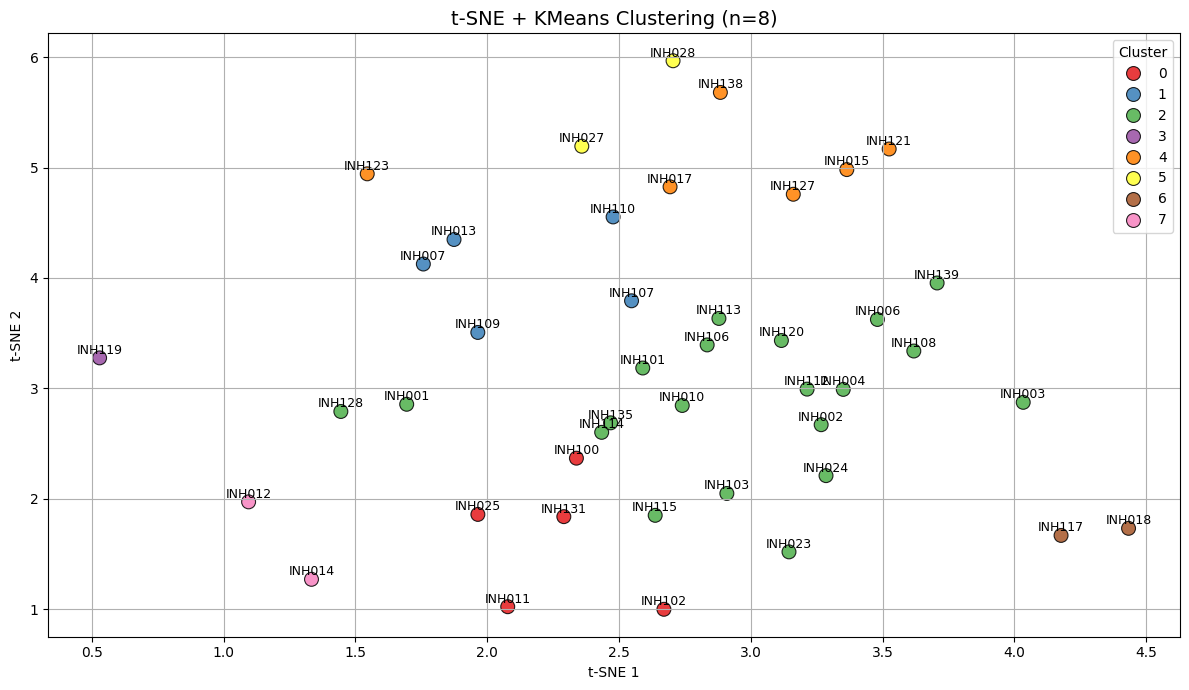

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Step 1: Scale the latent space
X = agg_all.values

X_scaled = StandardScaler().fit_transform(X)

# Store IDs
patient_ids = agg_all.index

# -----------------------------
# Step 2: Run t-SNE
tsne = TSNE(n_components=2, perplexity=25, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# -----------------------------
# Step 3: Run KMeans on same scaled data (not on t-SNE)
n_clusters = 8  # tweak as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster info to original data
agg_all['cluster'] = cluster_labels

# -----------------------------
# Step 4: Create plotting DataFrame
df_plot = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'cluster': cluster_labels,
    'patient_id': patient_ids
})

# -----------------------------
# Step 5: Plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='cluster',
    data=df_plot,
    palette='Set1',
    s=100,
    alpha=0.85,
    edgecolor='black'
)

# Add patient ID on top of each dot
for _, row in df_plot.iterrows():
    plt.text(
        row['TSNE1'],
        row['TSNE2'] + 0.01,  # 👈 vertical shift
        str(row['patient_id']),
        fontsize=9,
        ha='center',
        va='bottom'
    )
plt.title(f"t-SNE + KMeans Clustering (n={n_clusters})", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster')
plt.show()


In [ ]:
meta_clustered = meta_df.merge(
    agg_all[['cluster']],  # use only the cluster column
    left_on='patient_id',
    right_index=True,
    how='left'
)

In [ ]:
# Show 1 row per patient and the cluster they're assigned to
patient_cluster_map = meta_clustered[['patient_id', 'cluster']].drop_duplicates().sort_values('cluster')
print(patient_cluster_map)

       patient_id  cluster
46933      INH011        0
134146     INH102        0
93716      INH100        0
307995     INH131        0
381962     INH025        0
154909     INH107        1
221174     INH110        1
204604     INH109        1
358791     INH013        1
24061      INH007        1
81575      INH024        2
112917     INH101        2
184503     INH108        2
37057      INH010        2
75864      INH023        2
237027     INH112        2
336757     INH003        2
292722     INH128        2
326886     INH002        2
316421     INH139        2
263088     INH120        2
255499     INH115        2
169244     INH114        2
0          INH001        2
348748     INH006        2
473110     INH135        2
434016     INH113        2
414173     INH106        2
7754       INH004        2
399101     INH103        2
262479     INH119        3
59841      INH015        4
68212      INH127        4
281419     INH121        4
284911     INH123        4
311928     INH138        4
3

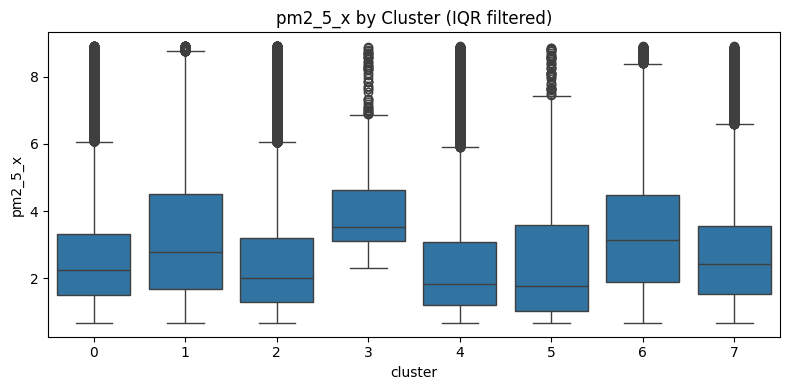

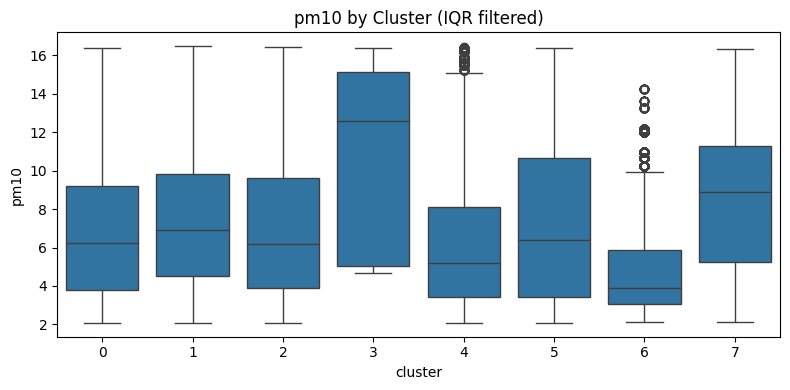

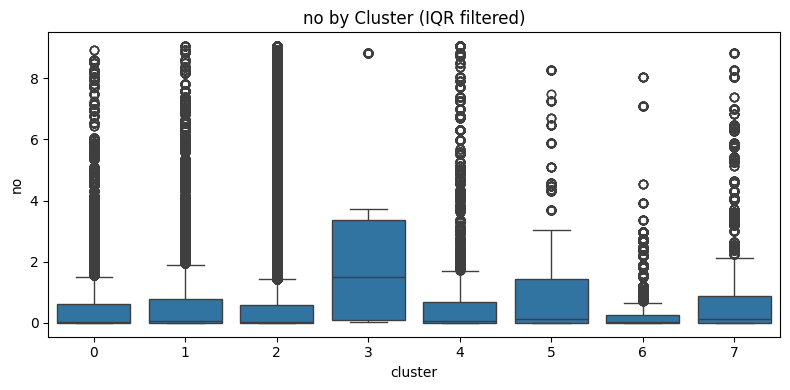

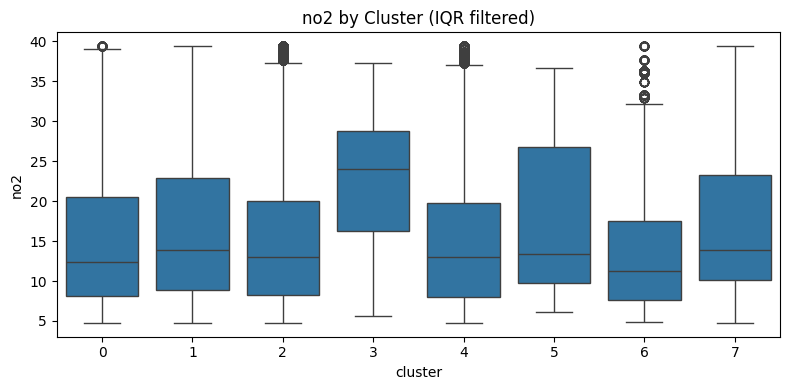

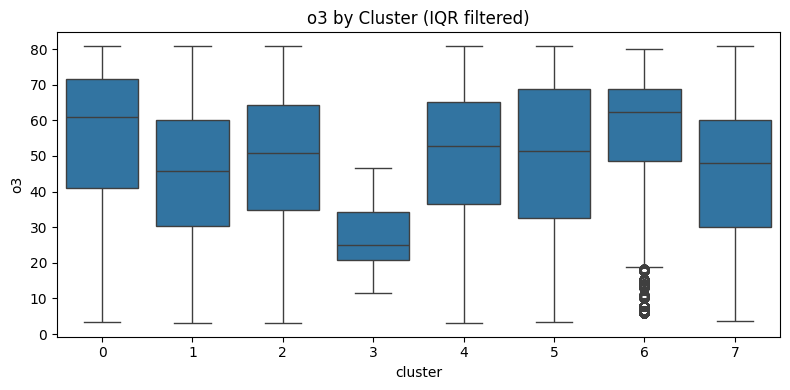

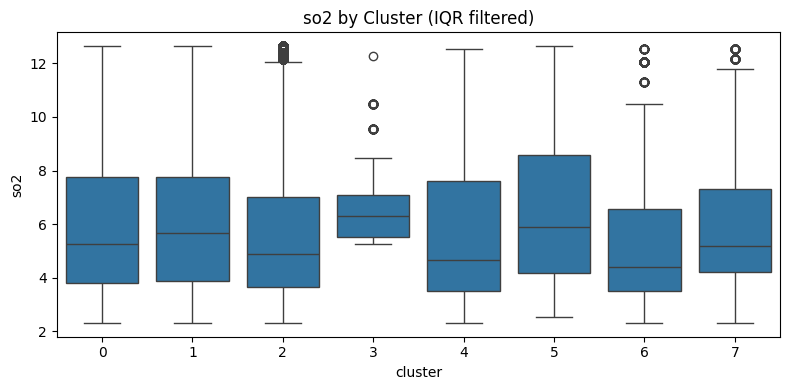

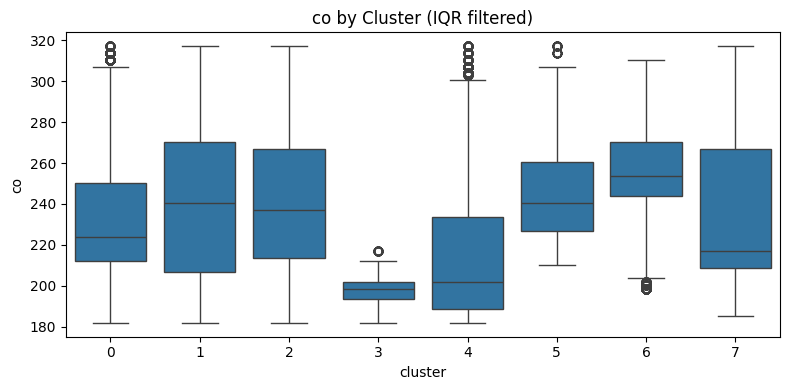

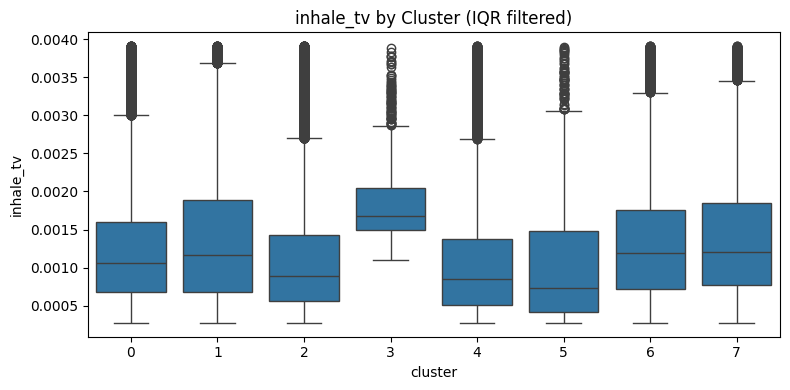

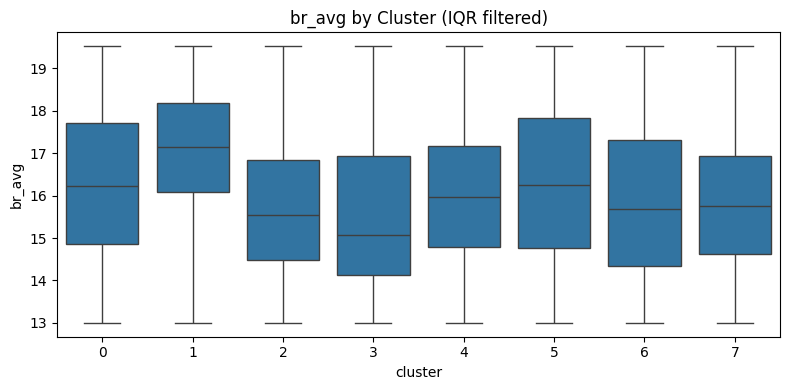

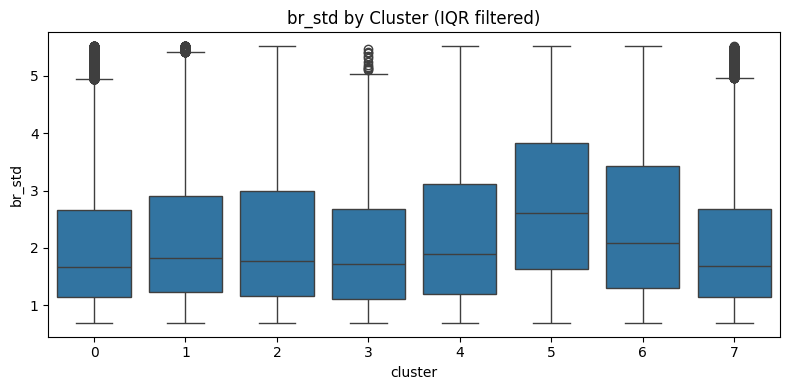

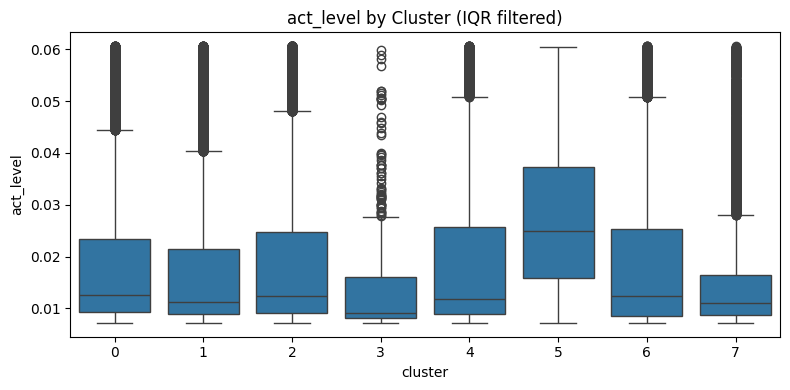

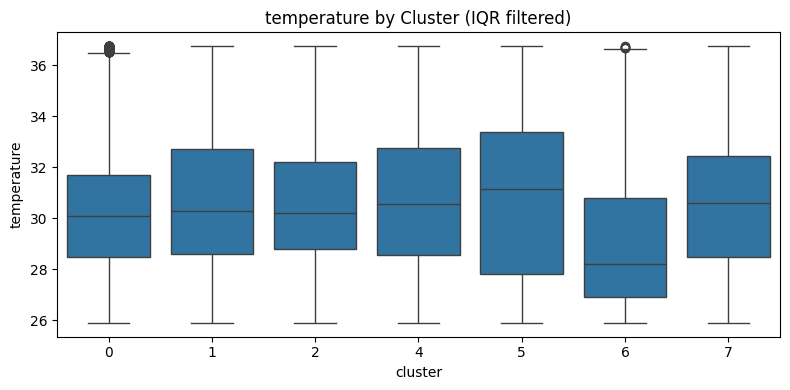

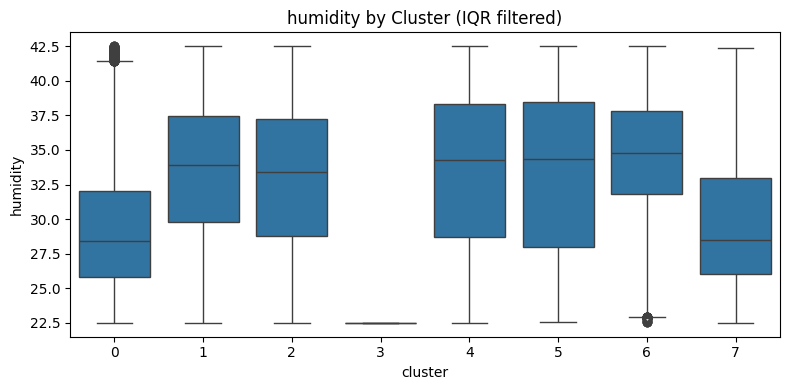

In [ ]:
features = ['pm2_5_x', 'pm10', 'no', 'no2', 'o3', 'so2', 'co',
            'inhale_tv', 'br_avg', 'br_std', 'act_level', 'temperature', 'humidity']

for col in features:
    # Compute IQR (Interquartile Range)
    Q1 = meta_clustered[col].quantile(0.10)
    Q3 = meta_clustered[col].quantile(0.90)
    IQR = Q3 - Q1

    # Keep only data within the IQR (optionally expand range slightly, e.g. 1.5 * IQR)
    lower = Q1
    upper = Q3
    filtered_df = meta_clustered[(meta_clustered[col] >= lower) & (meta_clustered[col] <= upper)]

    # Plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=filtered_df)
    plt.title(f"{col} by Cluster (IQR filtered)")
    plt.tight_layout()
    plt.show()

    ## Cluster 1 and 3 highest exposure to pm2_5 leading to greater inhalation and stornger physical responses with highest br_avg
    ## Cluster 5 highest activity levels, second highest level of inhalation!
    ## 2 and 4 have lowest exposure to pollution
    ## missing - 2, 4, 7


## Now Applying on one individual only

In [ ]:
# import copy
# import torch
# from torch.utils.data import DataLoader
# from sklearn.preprocessing import MinMaxScaler

# # ========================= 1. Extract and Normalize Individual Data =========================

# individual_id = 'INH111'

# # Scale individual data using the previously fitted scaler
# val_data_nn_scaled = scaler.transform(val_data_nn_pre[feature_cols])

# # ========================= 2. Wrap Individual Data in Dataset =========================

# val_dataset_individual = SlidingWindowDataset(val_data_nn_scaled, window_size, forecast_steps)
# val_loader_individual = DataLoader(val_dataset_individual, batch_size=batch_size, shuffle=True)

# # ========================= 3. Clone & Prepare Model =========================

# fine_tune_model = copy.deepcopy(model).to(device)

# fine_tune_optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, fine_tune_model.parameters()),
#     lr=1e-4
# )

# fine_tune_disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

# # ========================= 4. Fine-tune with Rollout Training =========================


# train_model_aae_rollout(
#     model=fine_tune_model,
#     train_loader=val_loader_individual,
#     val_loader=val_loader_individual,
#     optimizer=fine_tune_optimizer,
#     discriminator=discriminator,
#     disc_optimizer=fine_tune_disc_optimizer,
#     device=device,
#     epochs=5,
#     adv_weight=0.01,
#     scheduled_sampling_start=1.0,
#     scheduled_sampling_end=0.1,
#     scheduled_sampling_decay=0.9
# )

# # ========================= 5. Evaluate on Individual =========================

# print(f"\n🔍 Evaluation on Individual: {individual_id}")
# preds_ind, trues_ind = evaluate_model(
#     model=fine_tune_model,
#     dataloader=val_loader_individual,
#     device=device,
#     scaler=scaler,
#     feature_names=feature_cols
# )

# # Hourly-level evaluation
# print(f"\n🕒 Hourly Aggregated Evaluation for {individual_id}")
# preds_hourly_ind, trues_hourly_ind = evaluate_model_hourly(
#     model=fine_tune_model,
#     dataloader=val_loader_individual,
#     device=device,
#     scaler=scaler,
#     feature_names=feature_cols
# )

# # ========================= 6. Metrics =========================

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# print("\n🔢 Individual Metrics:")
# print(f"MSE: {mean_squared_error(trues_ind, preds_ind):.4f}")
# print(f"MAE: {mean_absolute_error(trues_ind, preds_ind):.4f}")
# print(f"R² Score: {r2_score(trues_ind, preds_ind):.4f}")

# print("\n📊 Per-feature Metrics:")
# for i, feature in enumerate(feature_cols):
#     mse = mean_squared_error(trues_ind[:, i], preds_ind[:, i])
#     mae = mean_absolute_error(trues_ind[:, i], preds_ind[:, i])
#     r2 = r2_score(trues_ind[:, i], preds_ind[:, i])
#     print(f"{feature}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# # ========================= 7. Save Fine-Tuned Model =========================

# torch.save(fine_tune_model.state_dict(), f"model_{individual_id}_finetuned_rollout.pt")
# print(f"\n✅ Fine-tuned rollout model for {individual_id} saved to model_{individual_id}_finetuned_rollout.pt")


In [ ]:
ciao

NameError: name 'ciao' is not defined

## Plotting Attention Measures

In [ ]:
# model.eval()

# # Take 1 sample from training set
# sample_input, _ = train_dataset[0]  # shape: (window_size, num_features)

# # Add batch dimension and permute to (seq_len, batch, features)
# sample_input = sample_input.unsqueeze(1).to(device)

# # Run through model
# with torch.no_grad():
#     _, _, _, attentions = model(sample_input)


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_attention_across_layers(attn, head=0, time_labels=None, figsize=(16, 10)):
#     """
#     Plots attention maps across all layers for a single head.

#     Args:
#         attn: list of attention tensors from each layer (batch, heads, seq_len, seq_len)
#         head: index of attention head to visualize
#         time_labels: optional list of time-step labels (length = seq_len)
#         figsize: size of the full figure
#     """
#     num_layers = len(attn)
#     seq_len = attn[0].shape[-1]

#     if time_labels is None:
#         time_labels = [f"t{i}" for i in range(seq_len)]

#     fig, axs = plt.subplots(2, (num_layers + 1) // 2, figsize=figsize)

#     for i in range(num_layers):
#         ax = axs[i // ((num_layers + 1) // 2)][i % ((num_layers + 1) // 2)]

#         attn_matrix = attn[i][0, head].detach().cpu().numpy()
#         sns.heatmap(attn_matrix,
#                     xticklabels=time_labels,
#                     yticklabels=time_labels,
#                     cmap="viridis",
#                     square=True,
#                     cbar=False,
#                     ax=ax)

#         ax.set_title(f"Layer {i}")
#         ax.set_xlabel("Key (past steps)")
#         ax.set_ylabel("Query (current step)")

#     plt.tight_layout()
#     plt.suptitle(f"Attention Across Layers — Head {head}", fontsize=16, y=1.05)
#     plt.show()

# sample_input, _ = train_dataset[0]
# sample_input = sample_input.unsqueeze(1).to(device)  # (seq_len, 1, features)

# model.eval()
# with torch.no_grad():
#     _, _, _, attentions = model(sample_input)

# # Plot attention maps across all layers for Head 0
# plot_attention_across_layers(attentions, head=0)



In [ ]:
# def plot_attention_across_heads(attn, layer=0, time_labels=None, figsize=(16, 10)):
#     """
#     Plots attention maps for all heads in a single Transformer layer.

#     Args:
#         attn: list of attention tensors from each layer (batch, heads, seq_len, seq_len)
#         layer: which layer to visualize
#         time_labels: optional list of time-step labels
#         figsize: size of the figure
#     """
#     attn_layer = attn[layer]  # (batch, heads, seq_len, seq_len)
#     num_heads = attn_layer.shape[1]
#     seq_len = attn_layer.shape[-1]

#     if time_labels is None:
#         time_labels = [f"t{i}" for i in range(seq_len)]

#     cols = (num_heads + 1) // 2
#     fig, axs = plt.subplots(2, cols, figsize=figsize)

#     for h in range(num_heads):
#         ax = axs[h // cols][h % cols]

#         attn_matrix = attn_layer[0, h].detach().cpu().numpy()
#         sns.heatmap(attn_matrix,
#                     xticklabels=time_labels,
#                     yticklabels=time_labels,
#                     cmap="viridis",
#                     square=True,
#                     cbar=False,
#                     ax=ax)

#         ax.set_title(f"Head {h}")
#         ax.set_xlabel("Key (past steps)")
#         ax.set_ylabel("Query (current step)")

#     plt.tight_layout()
#     plt.suptitle(f"Attention Across Heads — Layer {layer}", fontsize=16, y=1.05)
#     plt.show()


In [ ]:
# # Plot all heads in Layer 3
# plot_attention_across_heads(attentions, layer=3)

# # Typical differences between heads:

# # Some focus tightly on recent time steps (diagonal)

# # Others jump to the beginning (e.g., t0)

# # Some spread out attention → global heads



🔸 Local Heads:
Heads 0, 4, and 5 are heavily focused on recent steps

These are probably modeling short-term momentum, like immediate past → next prediction

🔸 Global/Semi-Global Heads:
Head 1: Strong on t0 and t7 (first and last steps!) → maybe learning positional anchors

Head 7: Gradual, smooth spread → good sign of global context scanning

🔸 Anchored Heads:
Head 3: Very consistent attention around t3, for all queries

This might indicate a fixed position dependency (e.g., daily rhythm at certain hours)

## FULL Threshold

In [ ]:
# import numpy as np
# import torch
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # ---- Define risk-relevant features ----
# risk_features = ['br_avg', 'br_std', 'act_level', 'pm10', 'no2', 'o3', 'pm2_5_x', 'so2']
# risk_indices = [feature_cols.index(f) for f in risk_features]

# # ---- Normalize selected risk vector only ----
# def normalize_risk_vector(vec, risk_indices, scaler):
#     # Select only the risk-related features from the input vector
#     # Check if vec is already a risk vector (size matches risk_indices)
#     if len(vec) == len(risk_indices):
#         risk_vec = vec  # It's already the risk vector
#     else:
#         risk_vec = vec[risk_indices] # Otherwise select risk features

#     dummy = np.zeros((1, scaler.n_features_in_))
#     dummy[0, risk_indices] = risk_vec  # Assign the risk features to the correct indices
#     dummy_scaled = scaler.transform(dummy)
#     return dummy_scaled[0, risk_indices]

# # ---- Risk classification from prediction ----
# def get_risk_from_prediction(
#     pred_vector, baseline_vector,
#     risk_indices,
#     scaler,
#     method="euclidean",
#     green_thresh=0.3,
#     yellow_thresh=1.0,
#     return_distance=False
# ):
#     pred_norm = normalize_risk_vector(pred_vector, risk_indices, scaler)
#     # Pass baseline_vector directly as it already only contains risk features
#     base_norm = normalize_risk_vector(baseline_vector, risk_indices, scaler)

#     if method == "euclidean":
#         dist = np.linalg.norm(pred_norm - base_norm)
#     else:
#         raise NotImplementedError("Only Euclidean distance supported")

#     if dist < green_thresh:
#         risk = "GREEN"
#     elif dist < yellow_thresh:
#         risk = "YELLOW"
#     else:
#         risk = "RED"

#     return (risk, dist) if return_distance else risk

# def get_baseline_prediction_vector(model, dataloader, device, scaler, risk_indices):
#     model.eval()
#     preds = []

#     with torch.no_grad():
#         for inputs, _ in dataloader:
#             inputs = inputs.permute(1, 0, 2).to(device)
#             output, _, _, _ = model(inputs)  # shape: (batch, features)
#             output = output.cpu().numpy()

#             for i in range(output.shape[0]):
#                 single_pred = output[i]  # shape: (features,)
#                 output_full = np.zeros((scaler.n_features_in_,))
#                 output_full[:single_pred.shape[0]] = single_pred
#                 output_original = scaler.inverse_transform(output_full.reshape(1, -1))[0]
#                 preds.append(output_original[risk_indices])

#     preds = np.stack(preds, axis=0)
#     return preds.mean(axis=0)  # shape: (len(risk_features),)


# # ---- Step-by-step risk tracking ----
# def scan_individual_risk(model, dataset, scaler, baseline_vector, risk_indices, device):
#     print("🕵️ Scanning risk across time...\n")
#     model.eval()
#     risks = []
#     distances = []

#     with torch.no_grad():
#         for step in range(len(dataset)):
#             input_step, _ = dataset[step]
#             input_step = input_step.unsqueeze(1).to(device)

#             output, _, _, _ = model(input_step)
#             output = output.squeeze().cpu().numpy()

#             # Inverse transform
#             output_full = np.zeros((scaler.n_features_in_,))
#             output_full[:output.shape[0]] = output
#             output_orig = scaler.inverse_transform(output_full.reshape(1, -1))[0]

#             risk, dist = get_risk_from_prediction(
#                 pred_vector=output_orig[risk_indices], # Pass only the risk features
#                 baseline_vector=baseline_vector,
#                 risk_indices=risk_indices,
#                 scaler=scaler,
#                 return_distance=True
#             )

#             # print(f"→ Distance from baseline: {dist:.4f}")
#             # print(f"Step {step:03d} → Risk: {risk}")
#             risks.append(risk)
#             distances.append(dist)
#     return risks, distances

In [ ]:
# # STEP 1: Get baseline prediction vector (per-person)
# baseline_pred_vector = get_baseline_prediction_vector(
#     model=fine_tune_model,
#     dataloader=val_loader_individual,
#     device=device,
#     scaler=scaler,
#     risk_indices=risk_indices
# )

# # STEP 2: Scan and classify risk
# risks, distances = scan_individual_risk(
#     model=fine_tune_model,
#     dataset=val_dataset_individual,
#     scaler=scaler,
#     baseline_vector=baseline_pred_vector,
#     risk_indices=risk_indices,
#     device=device
# )


In [ ]:
# plt.figure(figsize=(14, 5))
# plt.plot(distances, label="Distance from baseline", color='orange')
# plt.axhline(0.3, color='green', linestyle='--', label="GREEN threshold")
# plt.axhline(1.0, color='red', linestyle='--', label="RED threshold")
# plt.xlabel("Timestep")
# plt.ylabel("Distance from Baseline")
# plt.title("🧠 Risk Deviation Over Time")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

## THRESHOLD FILTERED by pollutant

In [ ]:
# x = val_data_nn_pre["pm2_5_x"]
# plt.figure(figsize=(8, 4))
# plt.hist(x, bins=500, color='skyblue', edgecolor='black')
# plt.axvline(15, color='green', linestyle='--', label='WHO Safe Limit (15)')
# plt.axvline(35, color='red', linestyle='--', label='High Risk Threshold (35)')
# plt.title("Histogram of PM2.5 Exposure")
# plt.xlabel("PM2.5 (μg/m³)")
# plt.ylabel("Frequency")
# plt.xlim(0, 100)  # 👈 Limits x-axis so extreme outliers don't ruin visibility
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# # STEP 1: Configuration
# pollution_var = "pm2_5_x"  # What pollutant to monitor
# pollution_index = feature_cols.index(pollution_var)

# # Features we care about (physiological + pollution)
# risk_features = ['br_avg', 'br_std', 'act_level', 'pm10', 'no2', 'o3', 'pm2_5_x', 'so2']
# risk_indices = [feature_cols.index(f) for f in risk_features]

# # STEP 2: Normalize a vector (for fair comparison)
# def normalize_risk_vector(vec, risk_indices, scaler):
#     if len(vec) == len(risk_indices):
#         risk_vec = vec  # Already a risk vector
#     else:
#         risk_vec = vec[risk_indices]  # Extract risk features from full vector

#     dummy = np.zeros((1, scaler.n_features_in_))
#     dummy[0, risk_indices] = risk_vec
#     return scaler.transform(dummy)[0, risk_indices]

# # STEP 3: Compute how reactive the person is to pollution
# def compute_reactivity_score(deviations, pollution_vals):
#     # Use percentiles to define "low" and "high" pollution
#     low, high = np.percentile(pollution_vals, [25, 75])
#     low_dev = [d for d, p in zip(deviations, pollution_vals) if p <= low]
#     high_dev = [d for d, p in zip(deviations, pollution_vals) if p > high]

#     avg_low = np.mean(low_dev) if low_dev else 0.0
#     avg_high = np.mean(high_dev) if high_dev else 0.0
#     return avg_low, avg_high, avg_high - avg_low, (low, high)

# # STEP 4: Get person’s baseline prediction (their “normal”)
# def get_baseline_vector(model, dataloader, device, scaler, risk_indices):
#     model.eval()
#     preds = []

#     with torch.no_grad():
#         for inputs, _ in dataloader:
#             inputs = inputs.permute(1, 0, 2).to(device)
#             output, _, _, _ = model(inputs)
#             output = output.cpu().numpy()

#             for pred in output:
#                 full = np.zeros(scaler.n_features_in_)
#                 full[:pred.shape[0]] = pred
#                 original = scaler.inverse_transform(full.reshape(1, -1))[0]
#                 preds.append(original[risk_indices])

#     return np.mean(preds, axis=0)

# # STEP 5: Scan over time for pollution + deviation alerts
# def scan_risk(model, dataset, scaler, baseline_vector, risk_indices, pollution_index, device):
#     model.eval()
#     deviations = []
#     pollution_vals = []

#     baseline_norm = normalize_risk_vector(baseline_vector, risk_indices, scaler)

#     with torch.no_grad():
#         for step in range(len(dataset)):
#             x, _ = dataset[step]
#             x = x.unsqueeze(1).to(device)
#             output, _, _, _ = model(x)
#             output = output.squeeze().cpu().numpy()

#             full = np.zeros(scaler.n_features_in_)
#             full[:output.shape[0]] = output
#             original = scaler.inverse_transform(full.reshape(1, -1))[0]

#             norm = normalize_risk_vector(original, risk_indices, scaler)
#             deviation = np.linalg.norm(norm - baseline_norm)
#             pollution = original[pollution_index]

#             print(f"Step {step:03d} → Pollution: {pollution:.1f} | Deviation: {deviation:.4f}")
#             deviations.append(deviation)
#             pollution_vals.append(pollution)

#     return deviations, pollution_vals

# # RUNNING EVERYTHING 🔽

# # Get baseline from validation data
# baseline = get_baseline_vector(
#     model=fine_tune_model,
#     dataloader=val_loader,
#     device=device,
#     scaler=scaler,
#     risk_indices=risk_indices
# )

# # Scan the time series
# deviations, pollution_vals = scan_risk(
#     model=fine_tune_model,
#     dataset=val_dataset,
#     scaler=scaler,
#     baseline_vector=baseline,
#     risk_indices=risk_indices,
#     pollution_index=pollution_index,
#     device=device
# )

# # Score reactivity
# avg_low, avg_high, reactivity_score, (low_thresh, high_thresh) = compute_reactivity_score(
#     deviations, pollution_vals
# )

# # REPORT
# print("\n🧠 Reactivity Report:")
# print(f"• Avg Deviation @ Low Pollution (≤ {low_thresh:.2f}): {avg_low:.4f}")
# print(f"• Avg Deviation @ High Pollution (> {high_thresh:.2f}): {avg_high:.4f}")
# print(f"• 🔥 Reactivity Score: {reactivity_score:.4f}")

# # Plot
# plt.figure(figsize=(14, 5))
# plt.plot(deviations, label="Deviation from Baseline", color="orange")
# plt.plot(pollution_vals, label="Pollution Level", color="blue", alpha=0.5)
# plt.xlabel("Time Step")
# plt.title("💨 Pollution & 📈 Risk Over Time")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# # --- Config ---
# pollution_var = "pm2_5_x"
# pollution_index = feature_cols.index(pollution_var)
# risk_features = ['br_avg', 'br_std', 'act_level', 'pm10', 'no2', 'o3', 'pm2_5_x', 'so2']
# risk_indices = [feature_cols.index(f) for f in risk_features]

# # --- Normalize only the selected risk features ---
# def normalize_risk_vector(vec, risk_indices, scaler):
#     if len(vec) == len(risk_indices):
#         risk_vec = vec
#     else:
#         risk_vec = vec[risk_indices]

#     full_vec = np.zeros((1, scaler.n_features_in_))
#     full_vec[0, risk_indices] = risk_vec
#     scaled = scaler.transform(full_vec)
#     return scaled[0, risk_indices]

# # --- Reactivity Score using pollution percentiles ---
# def compute_reactivity_score(deviations, pollution_vals):
#     low, high = np.percentile(pollution_vals, [25, 75])
#     low_dev = [d for d, p in zip(deviations, pollution_vals) if p <= low]
#     high_dev = [d for d, p in zip(deviations, pollution_vals) if p > high]
#     return (
#         np.mean(low_dev) if low_dev else 0.0,
#         np.mean(high_dev) if high_dev else 0.0,
#         (np.mean(high_dev) - np.mean(low_dev)) if high_dev and low_dev else 0.0,
#         (low, high)
#     )

# # --- Estimate baseline physiology ---
# def get_baseline_vector(model, dataloader, device, scaler, risk_indices):
#     model.eval()
#     preds = []

#     with torch.no_grad():
#         for inputs, _ in dataloader:
#             inputs = inputs.permute(1, 0, 2).to(device)
#             output, *_ = model(inputs)
#             output = output.cpu().numpy()

#             for pred in output:
#                 full = np.zeros(scaler.n_features_in_)
#                 full[:pred.shape[0]] = pred
#                 inverse = scaler.inverse_transform(full.reshape(1, -1))[0]
#                 preds.append(inverse[risk_indices])

#     return np.mean(preds, axis=0)

# # --- Time series scan ---
# def scan_risk(model, dataset, scaler, baseline_vector, risk_indices, pollution_index, device):
#     model.eval()
#     deviations, pollution_vals = [], []
#     baseline_norm = normalize_risk_vector(baseline_vector, risk_indices, scaler)

#     with torch.no_grad():
#         for step in range(len(dataset)):
#             x, _ = dataset[step]
#             x = x.unsqueeze(1).to(device)
#             output, *_ = model(x)
#             output = output.squeeze().cpu().numpy()

#             full = np.zeros(scaler.n_features_in_)
#             full[:output.shape[0]] = output
#             original = scaler.inverse_transform(full.reshape(1, -1))[0]

#             norm = normalize_risk_vector(original, risk_indices, scaler)
#             deviation = np.linalg.norm(norm - baseline_norm)
#             pollution = original[pollution_index]

#             deviations.append(deviation)
#             pollution_vals.append(pollution)

#     return deviations, pollution_vals

# # --- Run Pipeline ---
# baseline = get_baseline_vector(
#     model=fine_tune_model,
#     dataloader=val_loader_individual,
#     device=device,
#     scaler=scaler,
#     risk_indices=risk_indices
# )

# deviations, pollution_vals = scan_risk(
#     model=fine_tune_model,
#     dataset=val_dataset_individual,
#     scaler=scaler,
#     baseline_vector=baseline,
#     risk_indices=risk_indices,
#     pollution_index=pollution_index,
#     device=device
# )

# avg_low, avg_high, reactivity_score, (low_thresh, high_thresh) = compute_reactivity_score(
#     deviations, pollution_vals
# )

# # --- Report ---
# # print("\n🧠 Reactivity Report")
# # print(f"• Avg Deviation @ Low Pollution (≤ {low_thresh:.2f}): {avg_low:.4f}")
# # print(f"• Avg Deviation @ High Pollution (> {high_thresh:.2f}): {avg_high:.4f}")
# # print(f"• 🔥 Reactivity Score: {reactivity_score:.4f}")


In [ ]:
# import matplotlib.pyplot as plt

# # Define thresholds
# low_thresh, high_thresh = np.percentile(pollution_vals, [25, 75])
# dev_thresh = np.percentile(deviations, 75)  # Alert on high deviation

# # Find alerting points (both pollution & deviation are high)
# alerts = [(i, p, d) for i, (p, d) in enumerate(zip(pollution_vals, deviations))
#           if p > high_thresh and d > dev_thresh]

# # Create plot
# fig, ax1 = plt.subplots(figsize=(14, 5))

# # Primary Y-axis: Pollution
# ax1.set_xlabel("Timestep")
# ax1.set_ylabel("Pollution Level (µg/m³)", color="blue")
# ax1.plot(
#     pollution_vals,
#     label="Pollution Level",
#     color="blue",
#     alpha=1.0,         # fully opaque
#     linewidth=1.5      # thicker line
# )
# ax1.axhline(high_thresh, color="red", linestyle="--", label=f"75th Percentile ({high_thresh:.2f})")
# ax1.axhline(low_thresh, color="green", linestyle="--", label=f"25th Percentile ({low_thresh:.2f})")
# ax1.tick_params(axis='y', labelcolor='blue')

# # Secondary Y-axis: Deviation from Baseline
# ax2 = ax1.twinx()
# ax2.set_ylabel("Deviation from Baseline", color="orange")
# ax2.plot(deviations, label="Deviation from Baseline", color="orange", linewidth=1.5)
# ax2.axhline(dev_thresh, color="orange", linestyle=":", label=f"Dev Alert (> {dev_thresh:.2f})")
# ax2.tick_params(axis='y', labelcolor='orange')

# # Plot alert markers 🔔
# for i, p, d in alerts:
#     ax1.plot(i, p, "ro", markersize=4, alpha=0.6)
#     ax2.plot(i, d, "ro", markersize=4, alpha=0.6)

# # Title and legends
# plt.title("💨 Pollution & 📈 Risk Over Time")
# fig.tight_layout()

# # Handle legends from both axes
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
# plt.grid(True)
# plt.show()

In [ ]:
# ## Improved y-label ticks
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator

# # Define thresholds
# low_thresh, high_thresh = np.percentile(pollution_vals, [25, 75])
# dev_thresh = np.percentile(deviations, 75)  # Alert on high deviation

# # Find alerting points (both pollution & deviation are high)
# alerts = [(i, p, d) for i, (p, d) in enumerate(zip(pollution_vals, deviations))
#           if p > high_thresh and d > dev_thresh]

# # Create plot
# fig, ax1 = plt.subplots(figsize=(14, 5))

# # Primary Y-axis: Pollution
# ax1.set_xlabel("Timestep")
# ax1.set_ylabel("Pollution Level (µg/m³)", color="blue")
# ax1.plot(
#     pollution_vals,
#     label="Pollution Level",
#     color="blue",
#     alpha=1.0,
#     linewidth=1.5
# )

# # 🔁 More frequent y-ticks every 5 units
# ax1.yaxis.set_major_locator(MultipleLocator(20))

# ax1.axhline(high_thresh, color="red", linestyle="--", label=f"75th Percentile ({high_thresh:.2f})")
# ax1.axhline(low_thresh, color="green", linestyle="--", label=f"25th Percentile ({low_thresh:.2f})")
# ax1.tick_params(axis='y', labelcolor='blue')

# # Secondary Y-axis: Deviation from Baseline
# ax2 = ax1.twinx()
# ax2.set_ylabel("Deviation from Baseline", color="orange")
# ax2.plot(deviations, label="Deviation from Baseline", color="orange", linewidth=1.5)
# ax2.axhline(dev_thresh, color="orange", linestyle=":", label=f"Dev Alert (> {dev_thresh:.2f})")
# ax2.tick_params(axis='y', labelcolor='orange')

# # Plot alert markers 🔔
# for i, p, d in alerts:
#     ax1.plot(i, p, "ro", markersize=4, alpha=0.6)
#     ax2.plot(i, d, "ro", markersize=4, alpha=0.6)

# # Title and legends
# plt.title("💨 Pollution & 📈 Risk Over Time")
# fig.tight_layout()

# # Combine legends from both axes
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

# plt.grid(True)
# plt.show()


In [ ]:
## Visualise that what said above makes sense
## Where was the individual at timestep 5k and 7k?